In [62]:
%reload_ext autoreload
import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

# AWS imports: Import Braket SDK modules

from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np
from numpy.linalg import eigh

import functools
import time

from utils import DeviceUtils,DeviceScanner,BraketTaskScanner,Plotter, qasm_source
from hadamard_bench import *
from pyquil import get_qc
from quil_utils import *

import json
import pandas as pd
import seaborn as sns 
import networkx as nx

In [33]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
# rigetti = LocalSimulator()
#ion_q = LocalSimulator()

ds = DeviceScanner( device=rigetti)

ds.get_cost_infos()

a:b:c:us-west-1


{'task': 0.3, 'shot': 0.00035}

## Tomography


In [34]:
shots = 1000
#set_n_qubits = range(3,10)
n_qubits = 11
set_line_length = [5,10,15,20,25]
print(set_line_length)

[5, 10, 15, 20, 25]


In [36]:
tomo_tasks = []
labels = []

#0 gates circuit
circ = Circuit().h(range(n_qubits)).h(range(n_qubits))
circ_x, circ_y, circ_z = tomography_circuits(circ, circ.qubits)
#print(circ_x, circ_y, circ_z)

task_x = rigetti.run(circ_x,shots=shots)
task_y = rigetti.run(circ_y,shots=shots)
task_z = rigetti.run(circ_z,shots=shots)

tomo_tasks.extend((task_x,task_y,task_z))
labels.append( "rigetti_tomo_x_" + str(0))
labels.append( "rigetti_tomo_y_" + str(0))
labels.append( "rigetti_tomo_z_" + str(0))

for line_length in set_line_length:
    print(line_length)
    
    circ = Circuit().H_line(n_qubits,line_length,'Rigetti')
    circ = Circuit().add_verbatim_box(circ)

    circ_x, circ_y, circ_z = tomography_circuits(circ, circ.qubits)

    #print(circ_x, circ_y, circ_z)
    
    task_x = rigetti.run(circ_x,shots=shots,disable_qubit_rewiring=True)
    task_y = rigetti.run(circ_y,shots=shots,disable_qubit_rewiring=True)
    task_z = rigetti.run(circ_z,shots=shots,disable_qubit_rewiring=True)
    tomo_tasks.extend((task_x,task_y,task_z))
    labels.append( "rigetti_tomo_x_" + str(line_length))
    labels.append( "rigetti_tomo_y_" + str(line_length))
    labels.append( "rigetti_tomo_z_" + str(line_length))

5
10
15
20
25


In [38]:
print(tomo_tasks)
print(labels)

dump_tasks(tomo_tasks, labels, filename = "H_line_tomography")

[AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/bb963bb1-d540-4361-b986-addb4bb70fee'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/f92c51ef-c65a-42d4-933e-e93baeb2f5ec'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/9f4b0f11-41ea-4cb3-bf14-0782632bcb25'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/7263dcb0-5139-4a8b-8418-7fc7cf9f2dc6'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/de4a14d3-5ce3-4bda-9efb-500b3ab27fe0'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/b3f1246f-65a0-42ab-aaa6-932f58c94bbe'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/6737b965-6b0e-4db5-9983-142a81be058b'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/956563ed-9ed1-4f80-82e9-67679671419f'), AwsQuantumTask('id/taskArn':'arn:aws:br

In [47]:
tasks = load_tasks("H_line_ionq_grosso")
scanners = [BraketTaskScanner(qtask = task) for key, task in tasks.items()]

status = [task.get_status() for task in scanners]
cost = [task.cost_extimate() for task in scanners]
print(status, cost)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED'] [Decimal('10.3000000000'), Decimal('10.3000000000'), Decimal('10.3000000000'), Decimal('10.3000000000'), Decimal('10.3000000000')]


In [76]:
from typing import List

def get_tomography_results( scanners: List[BraketTaskScanner]):

    n_qubits = scanners[0].get_results().measured_qubits

    print(n_qubits)
    per_qubits = [result_per_qubit(sc.get_results()) for sc in scanners]

    density = []
    purity = []
    for qubit in n_qubits :

        counts_x = np.array(per_qubits[0][per_qubits[0].qubit_n == qubit]["counts"])
        counts_y = np.array(per_qubits[1][per_qubits[1].qubit_n == qubit]["counts"])
        counts_z = np.array(per_qubits[2][per_qubits[2].qubit_n == qubit]["counts"])
        #print(counts)

        x =  counts_x[1]/(counts_x[1]+counts_x[0])
        y =  counts_y[1]/(counts_y[1]+counts_y[0])
        z =  counts_z[1]/(counts_z[1]+counts_z[0])

        r = x**2 + y**2 +z**2
        purity.append((1+r)/2)
        x = x/r
        y = y/r
        z = z/r

        dmat = np.array([[1-z, x+ 1j*y],[x-1j*y, 1+z]], dtype=complex)
        density.append(dmat)

    return density,purity


density, purity = get_tomography_results( scanners[0:3])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Populating the interactive namespace from numpy and matplotlib


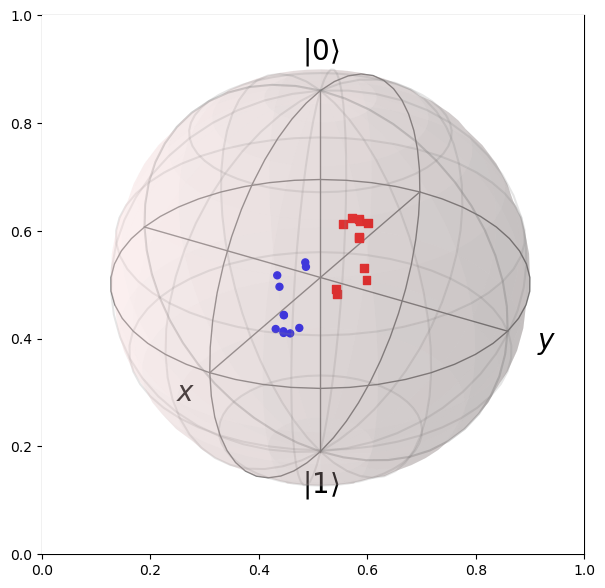

In [79]:
import qutip
%pylab inline

def plot_on_device(data, device : AwsDevice, rewiring_map = None, ax= None, cmap = "RdYlGn_r"):

    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (5,6))

    if rewiring_map == None:
        rewiring_map = {x:x for x in range(len(data))}

    graph = device.topology_graph

    col_vec = [ data[rewiring_map[x]] for x in range(len(data))]
    nx.draw_kamada_kawai(graph, with_labels=True, node_color=col_vec, node_size=300, cmap=cmap, vmin = 0, vmax = 1, ax = ax)


    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
    plt.colorbar(sm, cax=cax, orientation='vertical')

def plot_density_eigen( densities, fig = None):

    n_mat = len(densities)
    major = np.empty((3, n_mat))
    minor = np.empty((3, n_mat))


    for i in range(len(densities)):

        values, vectors = eigh(densities[i])

        mi = vectors[:,0]
        mj = vectors[:,1]

        minor[:,i] =( (np.abs(mi[1])**2-np.abs(mi[0])**2)/2, np.real( mi[0]*np.conj(mi[1])),np.imag( mi[0]*np.conj(mi[1])))
        major[:,i] =( (np.abs(mj[1])**2-np.abs(mj[0])**2)/2, np.real( mj[0]*np.conj(mj[1])),np.imag( mj[0]*np.conj(mj[1])))

    if fig == None:
        fig, ax = plt.subplots(1,1, figsize =(7,7))

    b=qutip.Bloch(axes=fig.add_subplot(1,1,1, projection='3d'))

    b.add_points([minor[1], minor[2], minor[0]])
    b.add_points([major[1], major[2], major[0]])
    b.make_sphere()
    #b.render()
    

    

        

plot_on_device( data = purity, device =DeviceUtils.get_device("ionq"))
plot_density_eigen(density)
